<a href="https://colab.research.google.com/github/rautaditya2606/Credit_card_fraud_detection/blob/main/Accredian_fraud_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection - Summary

**Notebook Overview:**  
- Performed **EDA** on transaction dataset to identify fraud patterns and high-risk accounts.  
- Conducted **feature engineering**, including creation of `errorBalanceOrig` and `errorBalanceDest` for anomaly detection.  
- Preprocessed data with **scaling** and **one-hot encoding**.  
- Trained an **XGBoost Classifier** to predict fraudulent transactions.  
- Evaluated model with **accuracy, precision, recall, and F1-score**.  
- Visualized **confusion matrix** and **feature importance**.  

**Key Results:**  
- Training Accuracy: 0.99989  
- Validation Accuracy: 0.99987  
- Test Accuracy: 0.99988  
- Precision (Fraud): 0.957  
- Recall (Fraud): 0.949  
- F1-score (Fraud): 0.953  

**Confusion Matrix:**

|             | Predicted Non-Fraud | Predicted Fraud |
|-------------|------------------|----------------|
| Actual Non-Fraud | 1,270,811       | 70             |
| Actual Fraud     | 83              | 1,560          |


In [ ]:
import opendatasets as od
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import matplotlib
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import opendatasets as od
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor, XGBClassifier
import joblib

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [ ]:
df = pd.read_csv('Fraud.csv')

In [ ]:
df.corr(numeric_only=True)['isFraud'].sort_values(ascending=False)

,isFraud
isFraud,1.000000
amount,0.074920
isFlaggedFraud,0.048705
day,0.032240
step,0.031226
oldbalanceOrg,0.009800
newbalanceDest,-0.000026
oldbalanceDest,-0.006276
newbalanceOrig,-0.008588


# EDA (Exploratry Data Analysis)

Text(0.5, 1.0, 'fraud vs no fraud (higly imbalanced)')

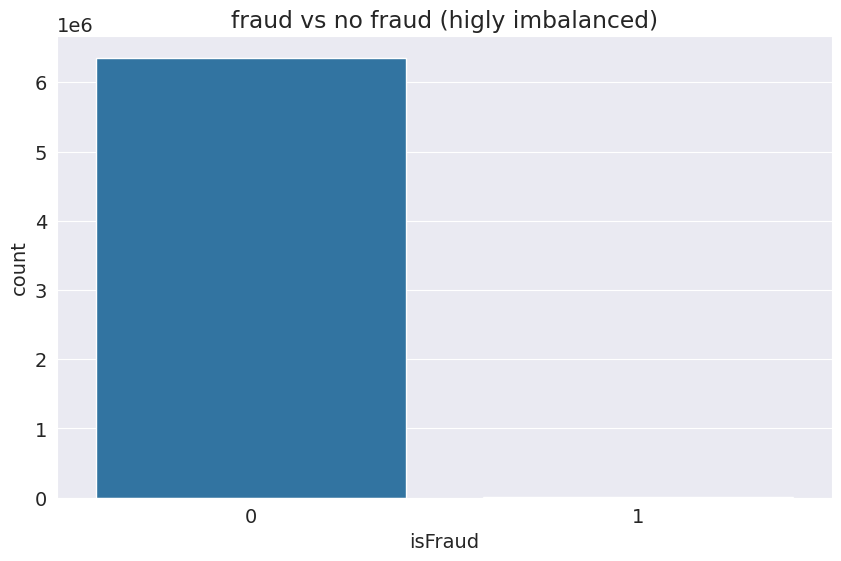

In [ ]:
sns.countplot(x='isFraud', data=df)
plt.title('fraud vs no fraud (higly imbalanced)')

# we can see the we cannot even see pixel on right side, this shows how higly imbalance it is

Text(0.5, 1.0, 'types of payment distribution')

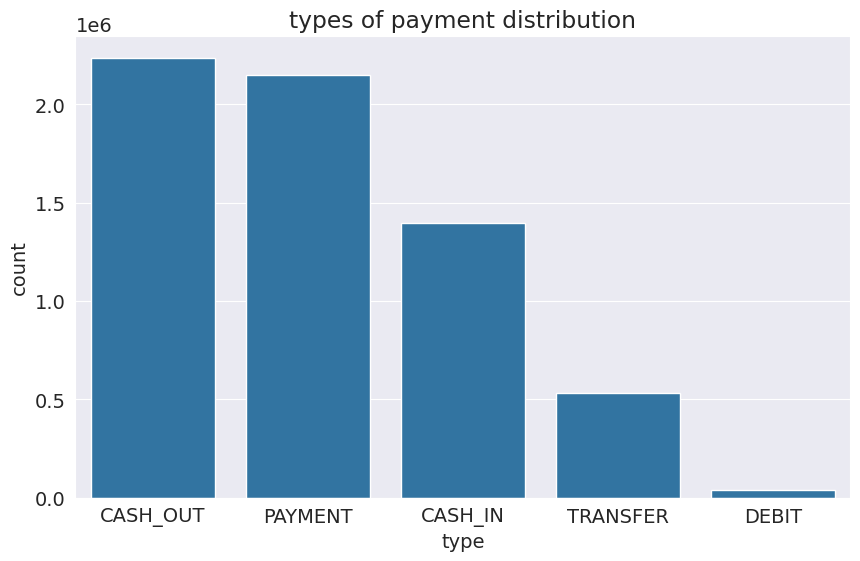

In [ ]:
sns.countplot(x='type', data=df, order=df['type'].value_counts().index)
plt.title('types of payment distribution')

# Cash is dominant here because it is  prefered by fraudster as it is not tracked

Text(0, 0.5, 'Fraud Probability')

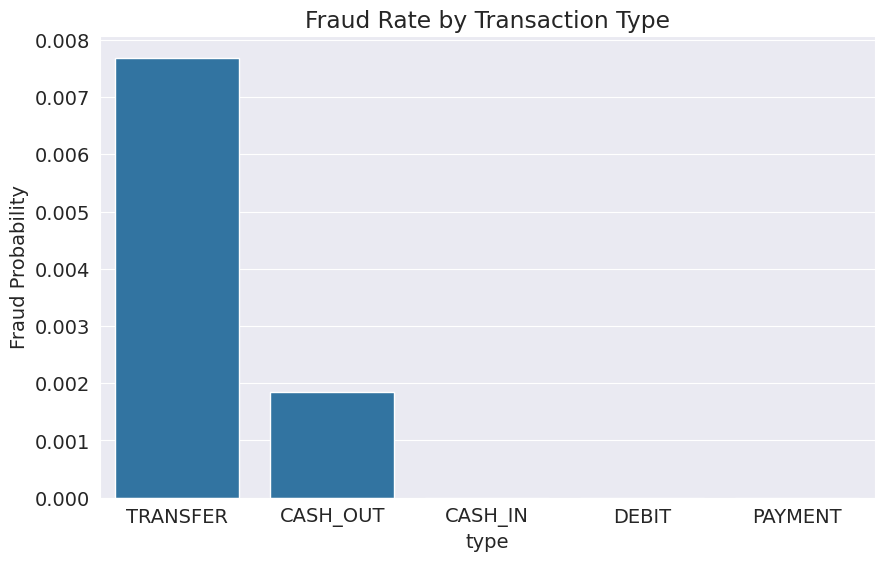

In [ ]:
fraud_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values)
plt.title("Fraud Rate by Transaction Type")
plt.ylabel("Fraud Probability")

<Axes: >

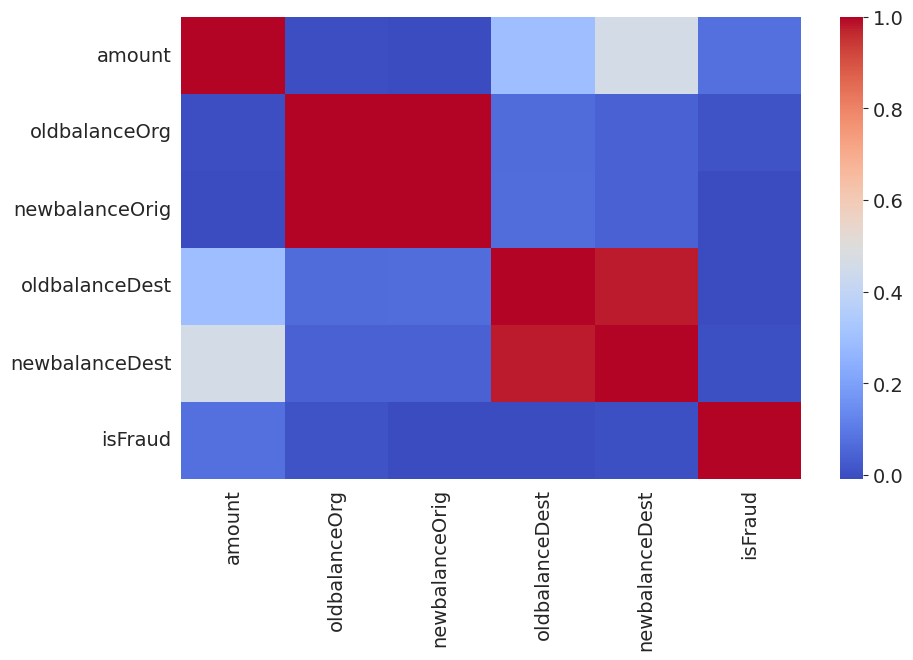

In [ ]:
sns.heatmap(df[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud']].corr(), cmap='coolwarm')

In [ ]:
df['day'] = df['step'] // 24

Text(0, 0.5, 'no of Frauds')

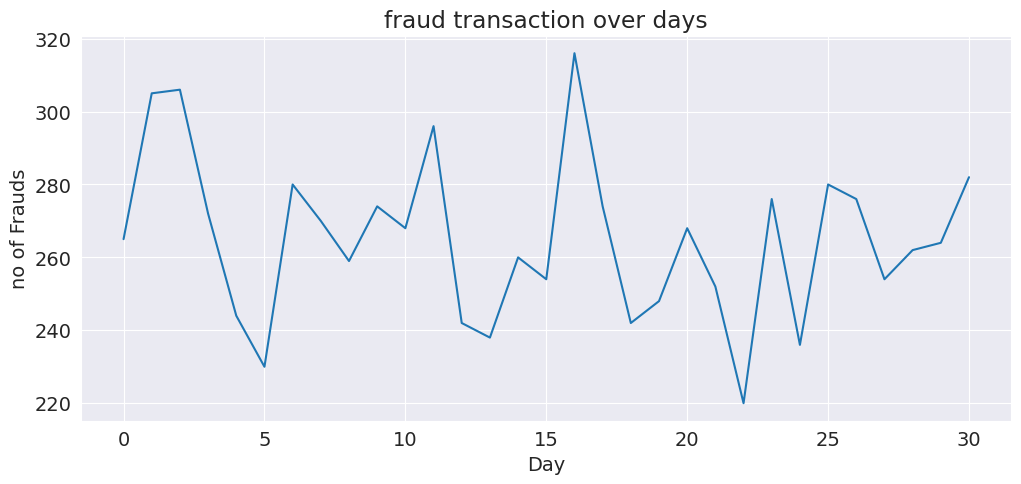

In [ ]:
fraud_per_day = df.groupby('day')['isFraud'].sum()
plt.figure(figsize=(12,5))
sns.lineplot(x=fraud_per_day.index, y=fraud_per_day.values)
plt.title("fraud transaction over days")
plt.xlabel("Day")
plt.ylabel("no of Frauds")

In [ ]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,30
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,30
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,30
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,30


In [ ]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'day'],
      dtype='object')

In [ ]:
df['nameOrig'].value_counts()

,count
nameOrig,
C1530544995,3
C545315117,3
C724452879,3
C1784010646,3
C1677795071,3
...,...
C1567523029,1
C644777639,1
C1256645416,1


In [ ]:
df['nameDest'].value_counts()

,count
nameDest,
C1286084959,113
C985934102,109
C665576141,105
C2083562754,102
C248609774,101
...,...
M367627425,1
M1902904124,1
M242332837,1


In [ ]:
fraud_dest = df[df['isFraud'] == 1]['nameDest'].value_counts()

In [ ]:
fraud_dest.head(10)

,count
nameDest,
C1981613973,2
C410033330,2
C1366192319,2
C1655359478,2
C803116137,2
C52390890,2
C1325541393,2
C904300960,2
C2020337583,2


In [ ]:
dest_stats = df.groupby('nameDest')['isFraud'].agg(['count','sum'])
dest_stats.rename(columns={'count':'total_txns','sum':'fraud_txns'}, inplace=True)
dest_stats['fraud_rate'] = dest_stats['fraud_txns'] / dest_stats['total_txns']
dest_stats.sort_values(by='fraud_rate', ascending=False).head(10)

,total_txns,fraud_txns,fraud_rate
nameDest,,,
C2092567505,1,1,1.0
C377087678,1,1,1.0
C708647273,1,1,1.0
C249184120,1,1,1.0
C1921605128,1,1,1.0
C2112724407,1,1,1.0
C221266057,1,1,1.0
C1806065948,1,1,1.0
C90395861,1,1,1.0


In [ ]:
dest_stats = df.groupby('nameDest')['isFraud'].agg(['count','sum'])
dest_stats.rename(columns={'count':'total_txns','sum':'fraud_txns'}, inplace=True)
dest_stats['fraud_rate'] = dest_stats['fraud_txns'] / dest_stats['total_txns']
suspicious_accounts = dest_stats[dest_stats['total_txns'] > 1].sort_values(by='fraud_rate', ascending=False).head(10)
print(suspicious_accounts)

             total_txns  fraud_txns  fraud_rate
nameDest                                       
C14138104             2           2    1.000000
C1837027614           2           2    1.000000
C686334805            2           2    1.000000
C1148781766           2           2    1.000000
C1827800010           3           2    0.666667
C2063022949           2           1    0.500000
C299512906            2           1    0.500000
C1601626536           2           1    0.500000
C16659988             2           1    0.500000
C958080037            2           1    0.500000


# Some accounts only receive fraudulent transactions, which shows they are mainly used for fraud

/tmp/ipython-input-365278775.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=suspicious_accounts.index, y=suspicious_accounts['fraud_rate'], palette="Reds")


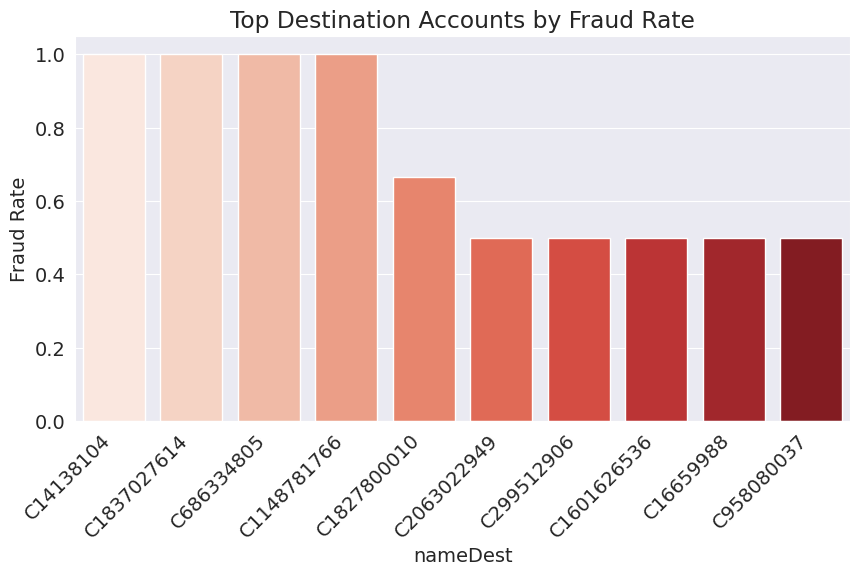

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=suspicious_accounts.index, y=suspicious_accounts['fraud_rate'], palette="Reds")
plt.xticks(rotation=45, ha="right")
plt.title("Top Destination Accounts by Fraud Rate")
plt.ylabel("Fraud Rate")
plt.show()

In [ ]:
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

# df['errorBalanceDest'] difference between expected new balance and actual new balance

In [ ]:
df['errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']

# df['errorBalanceOrig'] difference between expected old balance and recorded old balance

# preprocessing

In [ ]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,30
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,30
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,30
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,30


In [ ]:
input_cols = ['type', 'amount','oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'day', 'errorBalanceOrig', 'errorBalanceDest']
target_col = 'isFraud'

In [ ]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day,errorBalanceOrig,errorBalanceDest
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,0.0,9.839640e+03
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,0.0,1.864280e+03
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0.0,1.810000e+02
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0,0.0,2.136300e+04
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,0.0,1.166814e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,30,0.0,0.000000e+00
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,30,0.0,6.311409e+06
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,30,0.0,1.000000e-02
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,30,0.0,8.500025e+05


In [ ]:
# raw_df.corr(numeric_only=True)['isFraud'].sort_values(ascending=False)

In [ ]:
numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'day', 'errorBalanceOrig', 'errorBalanceDest']
categorical_cols = ['type']

In [ ]:
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['isFraud'])
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['isFraud'])

In [ ]:
scaler = MinMaxScaler().fit(train_df[numeric_cols])

# Scaling the numeric features from their values to 0-1 using MinMaxScaler()

In [ ]:
train_df[numeric_cols] = scaler.transform(train_df[numeric_cols])
val_df[numeric_cols] = scaler.transform(val_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

In [ ]:
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_df[categorical_cols])
encoded_cols = list(enc.get_feature_names_out(categorical_cols))

# encoding the categorical col (only one 'type'), it will convert to only type to type_CASH_IN,	type_CASH_OUT,	type_DEBIT,	type_PAYMENT,	type_TRANSFER

In [ ]:
train_df[encoded_cols] = enc.transform(train_df[categorical_cols])
val_df[encoded_cols] = enc.transform(val_df[categorical_cols])
test_df[encoded_cols] = enc.transform(test_df[categorical_cols])

# merging both numeric and categorical col to create training, validation and test dataset

In [ ]:
x_train = train_df[numeric_cols+encoded_cols]
x_val = val_df[numeric_cols+encoded_cols]
x_test = test_df[numeric_cols+encoded_cols]
y_train = train_df[target_col]
y_val = val_df[target_col]
y_test = test_df[target_col]

In [ ]:
x_train

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,day,errorBalanceOrig,errorBalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
3563112,0.000121,0.000800,0.000737,0.000000,0.000000,0.333333,1.081718e-10,0.835683,0.0,0.0,0.0,1.0,0.0
4931101,0.011005,0.003910,0.000000,0.000888,0.003744,0.466667,8.484200e-03,0.835544,0.0,0.0,0.0,0.0,1.0
5724608,0.000287,0.000290,0.000000,0.000000,0.000000,0.533333,9.951397e-05,0.835874,0.0,0.0,0.0,1.0,0.0
5436890,0.001663,0.000000,0.000000,0.000772,0.001203,0.500000,1.663419e-03,0.835544,0.0,1.0,0.0,0.0,0.0
863534,0.001727,0.000578,0.003914,0.000000,0.000000,0.033333,3.453515e-03,0.837534,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3987335,0.005714,0.181989,0.229344,0.001792,0.000308,0.400000,1.142738e-02,0.848714,1.0,0.0,0.0,0.0,0.0
4491191,0.001597,0.000000,0.000000,0.007165,0.007576,0.433333,1.597451e-03,0.835544,0.0,1.0,0.0,0.0,0.0
93276,0.002564,0.000000,0.000000,0.005431,0.008283,0.000000,2.564269e-03,0.825823,0.0,0.0,0.0,0.0,1.0
4673760,0.001493,0.000338,0.000000,0.000148,0.000536,0.433333,1.274701e-03,0.835544,0.0,1.0,0.0,0.0,0.0


# Baseline model (random guesser)

In [ ]:
random_guesser = np.random.choice([0,1], size = len(y_test))

In [ ]:
accuracy_random = accuracy_score(y_test, random_guesser)

In [ ]:
print("Random baseline accuracy:", accuracy_random)

Random baseline accuracy: 0.5007292593302759


# Training Model

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
model = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, colsample_bytree=0.8, n_jobs=-1, eval_metric='auc').fit(x_train, y_train,)

In [ ]:
train_preds = model.predict(x_train)

In [ ]:
train_acc = accuracy_score(y_train, train_preds)
print('Training Prediction: ',train_acc)

Training Prediction:  0.9998929293068204


In [ ]:
val_preds = model.predict(x_val)

In [ ]:
val_acc = accuracy_score(y_val, val_preds)
print('Validation Prediction: ',val_acc)

Validation Prediction:  0.999874265731518


In [ ]:
test_preds = model.predict(x_test)

In [ ]:
test_acc = accuracy_score(y_test, test_preds)
print('Testing Prediction: ',test_acc)

Testing Prediction:  0.99987976651128


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
test_confuse = confusion_matrix(y_test,  test_preds)

Text(0.5, 1.0, 'Confusion Matrix')

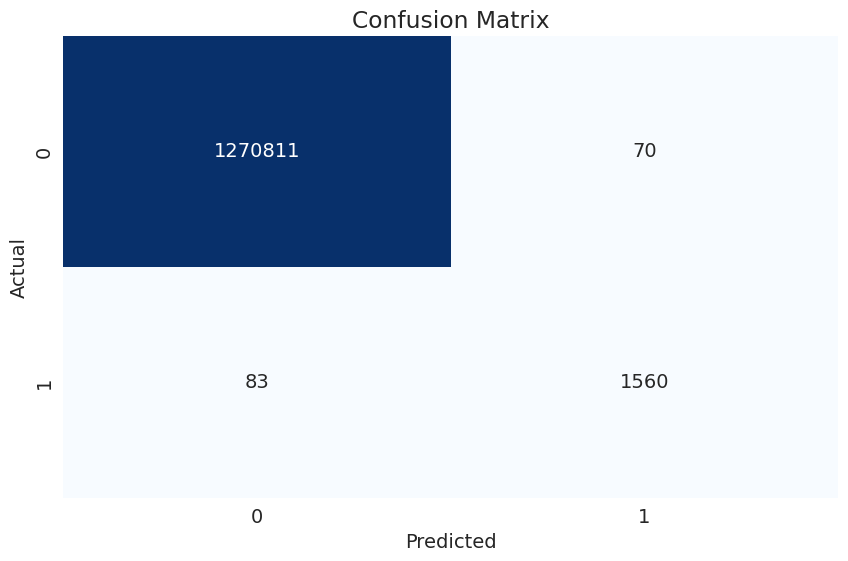

In [ ]:
sns.heatmap(test_confuse, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Shows how well the model distinguishes fraud vs. non-fraud transactions. Diagonal cells are correct predictions, and off-diagonal cells are misclassifications.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
print("Precision (fraud):", precision_score(y_test, test_preds))

Precision (fraud): 0.9570552147239264


In [ ]:
print("Recall (fraud):", recall_score(y_test, test_preds))

Recall (fraud): 0.9494826536822885


In [ ]:
print("F1-score (fraud):", f1_score(y_test, test_preds))

F1-score (fraud): 0.9532538955087076


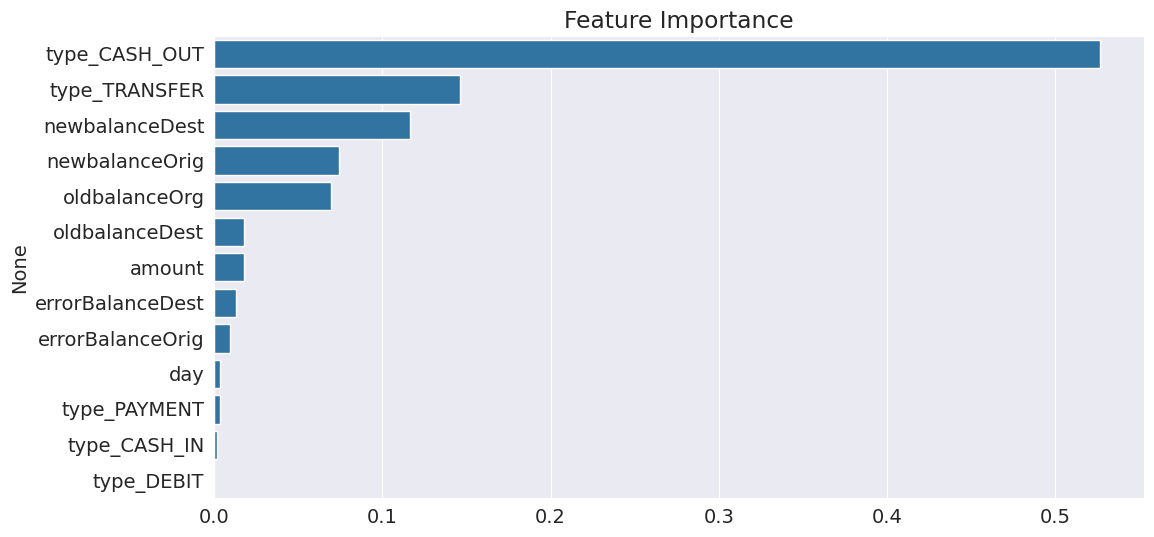

In [ ]:
importances = pd.Series(model.feature_importances_, index=numeric_cols + encoded_cols).sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature Importance")
plt.show()

In [ ]:
top_features = importances.head(10)
print("Top 10 features correlating fraud:\n", top_features)

Top 10 features correlating fraud:
 type_CASH_OUT       0.526553
type_TRANSFER       0.146265
newbalanceDest      0.116692
newbalanceOrig      0.074195
oldbalanceOrg       0.069169
oldbalanceDest      0.018001
amount              0.017894
errorBalanceDest    0.012899
errorBalanceOrig    0.009455
day                 0.003745
dtype: float32
